In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

import matplotlib.pyplot as plt

## Import Data
<p>
Import data from csv and print head of df
<p>
Data dictionary in repo.

In [2]:
df = pd.read_csv('ISM647_ML1_data.csv')

df.head(10)

,AcctAge,DDA,DDABal,CashBk,Checks,DirDep,NSF,NSFAmt,Phone,Teller,...,CRScore,Moved,InArea,Ins,Branch,Res,Dep,DepAmt,Inv,InvBal
0,0.3,1,419.27,0,0,0,0,0.00,0.0,0,...,696.0,0,1,1,B17,R,2,1170.06,0.0,0.0
1,0.7,1,1986.81,0,1,1,0,0.00,0.0,0,...,674.0,0,1,0,B2,R,1,446.93,0.0,0.0
2,4.1,0,0.00,0,0,0,0,0.00,0.0,0,...,640.0,0,1,1,B3,S,0,0.00,0.0,0.0
3,0.5,1,1594.84,0,1,0,0,0.00,0.0,1,...,672.0,0,1,0,B1,S,1,1144.24,0.0,0.0
4,6.7,1,2813.45,0,2,0,0,0.00,0.0,5,...,648.0,0,1,1,B1,S,2,1208.94,0.0,0.0
5,12.3,1,1069.78,0,13,1,0,0.00,2.0,9,...,662.0,0,1,1,B7,U,5,6813.58,0.0,0.0
6,8.8,1,1437.57,0,12,1,0,0.00,0.0,0,...,659.0,0,1,0,B1,U,2,2237.69,0.0,0.0
7,9.3,1,1683.28,0,2,1,0,0.00,0.0,0,...,675.0,0,1,1,B5,U,3,795.85,0.0,0.0
8,0.8,1,190.03,0,1,0,1,5.65,NaN,0,...,642.0,0,1,0,B14,S,3,880.25,NaN,NaN
9,0.9,1,462.12,0,4,0,0,0.00,0.0,2,...,667.0,0,1,1,B6,S,2,1049.57,0.0,0.0


## Inspect the Data: Dataframe Info 

32264 records with 48 features

In [3]:
# create function to describe numeric data to include the number of nulls and data type

def describe_with_nulls_and_dtype(num_df):
    # Get the basic description.
    description = num_df.describe(include='all').T  # Transpose for better readability
    
    # Calculate the number of nulls for each column.
    null_counts = num_df.isnull().sum()
    
    # Get the data types of each column.
    dtypes = num_df.dtypes
    
    # Add the null counts and data types to the description.
    description['nulls'] = null_counts
    description['dtype'] = dtypes

    # add percentage of nulls to the description
    description['percent_null'] = description['nulls'] / num_df.shape[0]

    # add the variance to the description
    description['variance'] = num_df.var().astype('int64')
    
    # Sort by data type, then by number of nulls.
    description = description.sort_values(['dtype','nulls',], ascending=[True, False])
      
    return description

### Statistical values for integer as categorical features

In [4]:
# select int columns used as categorical features
int_cat_features = df.select_dtypes(include=['int64'])
int_cat_features = int_cat_features.loc[:, int_cat_features.nunique() == 2]

# print statistical summary of the data for numerical features
describe_with_nulls_and_dtype(int_cat_features)


,count,mean,std,min,25%,50%,75%,max,nulls,dtype,percent_null,variance
DDA,32264.0,0.815646,0.387779,0.0,1.0,1.0,1.0,1.0,0,int64,0.0,0
DirDep,32264.0,0.295562,0.456302,0.0,0.0,0.0,1.0,1.0,0,int64,0.0,0
NSF,32264.0,0.087063,0.281932,0.0,0.0,0.0,0.0,1.0,0,int64,0.0,0
Sav,32264.0,0.466898,0.498911,0.0,0.0,0.0,1.0,1.0,0,int64,0.0,0
ATM,32264.0,0.609937,0.487772,0.0,0.0,1.0,1.0,1.0,0,int64,0.0,0
CD,32264.0,0.125837,0.331671,0.0,0.0,0.0,0.0,1.0,0,int64,0.0,0
IRA,32264.0,0.053279,0.224593,0.0,0.0,0.0,0.0,1.0,0,int64,0.0,0
LOC,32264.0,0.063383,0.243655,0.0,0.0,0.0,0.0,1.0,0,int64,0.0,0
ILS,32264.0,0.049591,0.217102,0.0,0.0,0.0,0.0,1.0,0,int64,0.0,0
MM,32264.0,0.114896,0.318901,0.0,0.0,0.0,0.0,1.0,0,int64,0.0,0


### Statistical values for non-categorical numeric features

In [5]:
# select numeric columns not included in the int_cat_features
num_features = df.select_dtypes(include=['int64', 'float64'])
num_features = num_features.loc[:, num_features.nunique() > 2]

# print statistical summary of the data for numerical features
describe_with_nulls_and_dtype(num_features)

,count,mean,std,min,25%,50%,75%,max,nulls,dtype,percent_null,variance
CashBk,32264.0,0.015962,0.131368,0.00,0.00,0.000,0.0000,4.00,0,int64,0.000000,0
Checks,32264.0,4.259918,5.156643,0.00,0.00,2.000,7.0000,49.00,0,int64,0.000000,26
Teller,32264.0,1.365268,2.283765,0.00,0.00,0.000,2.0000,27.00,0,int64,0.000000,5
CDBal,32264.0,2530.709150,14811.780979,0.00,0.00,0.000,0.0000,1053900.00,0,int64,0.000000,219388855
MMCred,32264.0,0.056379,0.287484,0.00,0.00,0.000,0.0000,5.00,0,int64,0.000000,0
Dep,32264.0,2.134608,1.721797,0.00,1.00,2.000,3.0000,28.00,0,int64,0.000000,2
Age,25907.0,47.928321,14.110848,16.00,38.00,48.000,58.0000,94.00,6357,float64,0.197031,199
Income,26482.0,40.588928,28.514979,0.00,20.00,35.000,55.0000,233.00,5782,float64,0.179209,813
LORes,26482.0,7.005664,2.838015,0.50,4.50,6.500,9.0000,19.50,5782,float64,0.179209,8
HMVal,26482.0,110.912129,21.949921,67.00,98.00,107.000,120.0000,754.00,5782,float64,0.179209,481


### Inspect string values used as categorical features.

In [6]:
def print_string_feature_values(df):
    # select string features
    string_features = df.select_dtypes(include=['object', 'string'])

    # print values for each of the string features
    for column in string_features:
        print(string_features[column].value_counts())
        print("\n")
    
    # print the number of nulls for each of the string features
    print('Number of nulls for each string feature:')
    print(string_features.isnull().sum())

    # print the percentage of nulls for each of the string features
    print('Percentage of nulls for each string feature:')
    print(string_features.isnull().sum() / string_features.shape[0])


In [7]:
# call the function on the dataframe
print_string_feature_values(df)

Branch
B4     5633
B2     5345
B3     2844
B1     2819
B5     2752
B15    2235
B16    1534
B6     1438
B7     1413
B8     1341
B14    1072
B17     850
B9      558
B12     549
B18     541
B13     535
B19     285
B10     273
B11     247
Name: count, dtype: int64


Res
U    12681
S    11506
R     8077
Name: count, dtype: int64


Number of nulls for each string feature:
Branch    0
Res       0
dtype: int64
Percentage of nulls for each string feature:
Branch    0.0
Res       0.0
dtype: float64


## Remove Unhelpful Features & Rows with Null Values

Removing for possible discriminatory reasons: Branch
<p>
Remove for low variance of numerical values: CashBk, CCPurch, MMCred, Phone
<p>


In [8]:
# remove uhelpful features from the dataframe. Save as new dataframe
df_cleaned = df.drop(['Branch','CashBk','CCPurc','MMCred','Phone'], axis=1)

# drops rows with missing values
df_cleaned = df_cleaned.dropna()

# print the statistical summary of the cleaned dataframe
df_cleaned.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
AcctAge,20877.0,5.701293,6.174029,0.30,1.90,3.90,6.50,61.50
DDA,20877.0,0.820760,0.383563,0.00,1.00,1.00,1.00,1.00
DDABal,20877.0,2156.619236,7530.748184,-774.83,62.52,555.59,1779.90,278093.83
Checks,20877.0,4.120803,5.051826,0.00,0.00,2.00,6.00,49.00
DirDep,20877.0,0.289266,0.453432,0.00,0.00,0.00,1.00,1.00
NSF,20877.0,0.087800,0.283011,0.00,0.00,0.00,0.00,1.00
NSFAmt,20877.0,2.272034,13.165138,0.00,0.00,0.00,0.00,416.37
Teller,20877.0,1.347703,2.247617,0.00,0.00,0.00,2.00,25.00
Sav,20877.0,0.466638,0.498898,0.00,0.00,0.00,1.00,1.00
SavBal,20877.0,3184.465080,13859.853110,0.00,0.00,0.00,1199.84,700026.94


## Start Machine Learning Processing
<p>
Create a target variable


In [9]:
# rename Ins column to target and move to first column in df_cleaned
df_cleaned.rename(columns={'Ins': 'target'}, inplace=True)
df_cleaned = df_cleaned[['target'] + [col for col in df_cleaned.columns if col != 'target']]

# print the first 5 rows of the cleaned dataframe
df_cleaned.head()

,target,AcctAge,DDA,DDABal,Checks,DirDep,NSF,NSFAmt,Teller,Sav,...,HMVal,Age,CRScore,Moved,InArea,Res,Dep,DepAmt,Inv,InvBal
0,1,0.3,1,419.27,0,0,0,0.0,0,1,...,89.0,63.0,696.0,0,1,R,2,1170.06,0.0,0.0
1,0,0.7,1,1986.81,1,1,0,0.0,0,0,...,87.0,51.0,674.0,0,1,R,1,446.93,0.0,0.0
2,1,4.1,0,0.00,0,0,0,0.0,0,0,...,97.0,60.0,640.0,0,1,S,0,0.00,0.0,0.0
3,0,0.5,1,1594.84,1,0,0,0.0,1,1,...,145.0,44.0,672.0,0,1,S,1,1144.24,0.0,0.0
4,1,6.7,1,2813.45,2,0,0,0.0,5,1,...,101.0,46.0,648.0,0,1,S,2,1208.94,0.0,0.0


## Encode categorical string features

In [10]:
# expand categorical string features in Res column into separate columns
df_encoded = pd.get_dummies(df_cleaned, columns=['Res'], dtype='int64')

# rename Res columns to include the original value
df_encoded.rename(columns={'Res_0': 'Rural', 'Res_1': 'Suburban', 'Res_2':'Urban'}, inplace=True)

# check the first 5 rows of the encoded dataframe
df_encoded.head()

# check the shape of the encoded dataframe
describe_with_nulls_and_dtype(df_encoded)

,count,mean,std,min,25%,50%,75%,max,nulls,dtype,percent_null,variance
target,20877.0,0.359439,0.479847,0.00,0.00,0.00,1.00,1.00,0,int64,0.0,0
DDA,20877.0,0.820760,0.383563,0.00,1.00,1.00,1.00,1.00,0,int64,0.0,0
Checks,20877.0,4.120803,5.051826,0.00,0.00,2.00,6.00,49.00,0,int64,0.0,25
DirDep,20877.0,0.289266,0.453432,0.00,0.00,0.00,1.00,1.00,0,int64,0.0,0
NSF,20877.0,0.087800,0.283011,0.00,0.00,0.00,0.00,1.00,0,int64,0.0,0
Teller,20877.0,1.347703,2.247617,0.00,0.00,0.00,2.00,25.00,0,int64,0.0,5
Sav,20877.0,0.466638,0.498898,0.00,0.00,0.00,1.00,1.00,0,int64,0.0,0
ATM,20877.0,0.612732,0.487137,0.00,0.00,1.00,1.00,1.00,0,int64,0.0,0
CD,20877.0,0.126120,0.331992,0.00,0.00,0.00,0.00,1.00,0,int64,0.0,0
CDBal,20877.0,2507.759736,14350.283691,0.00,0.00,0.00,0.00,688700.00,0,int64,0.0,205930642


## Normalize Numeric Values

Normalize float64 features within encoded dataset

In [11]:
def normalize_floats(df, columns, method='min-max'):
    # Copy the DataFrame to avoid modifying the original data
    df_normalized = df.copy()
    
    # Iterate over the specified columns
    for column in columns:
        if column in df_normalized.columns:
            if method == 'min-max':
                # Apply Min-Max normalization
                column_min = df_normalized[column].min()
                column_max = df_normalized[column].max()
                df_normalized[column] = (df_normalized[column] - column_min) / (column_max - column_min)
            elif method == 'z-score':
                # Apply Z-score normalization
                column_mean = df_normalized[column].mean()
                column_std = df_normalized[column].std()
                df_normalized[column] = (df_normalized[column] - column_mean) / column_std
            else:
                raise ValueError("Unsupported normalization method. Choose 'min-max' or 'z-score'.")
        else:
            print(f"Column '{column}' not found in the DataFrame.")
    
    return df_normalized

In [12]:
# select non-categorical float & int features to normalize
non_cat_features = df_encoded.select_dtypes(include=['int64', 'float64'])
non_cat_features = non_cat_features.loc[:, non_cat_features.nunique() > 2]

# create a list of the non-categorical features to normalize
non_cat_features = list(non_cat_features.columns)

print(non_cat_features)

['AcctAge', 'DDABal', 'Checks', 'NSFAmt', 'Teller', 'SavBal', 'ATMAmt', 'POS', 'POSAmt', 'CDBal', 'IRABal', 'LOCBal', 'ILSBal', 'MMBal', 'MTGBal', 'CCBal', 'Income', 'LORes', 'HMVal', 'Age', 'CRScore', 'Dep', 'DepAmt', 'InvBal']


In [13]:
# copy the encoded dataframe to a new dataframe
df_encoded_norm = normalize_floats(df_encoded, non_cat_features, method='min-max')

# check the shape of the encoded dataframe
describe_with_nulls_and_dtype(df_encoded_norm)

,count,mean,std,min,25%,50%,75%,max,nulls,dtype,percent_null,variance
target,20877.0,0.359439,0.479847,0.0,0.000000,0.000000,1.000000,1.0,0,int64,0.0,0
DDA,20877.0,0.820760,0.383563,0.0,1.000000,1.000000,1.000000,1.0,0,int64,0.0,0
DirDep,20877.0,0.289266,0.453432,0.0,0.000000,0.000000,1.000000,1.0,0,int64,0.0,0
NSF,20877.0,0.087800,0.283011,0.0,0.000000,0.000000,0.000000,1.0,0,int64,0.0,0
Sav,20877.0,0.466638,0.498898,0.0,0.000000,0.000000,1.000000,1.0,0,int64,0.0,0
ATM,20877.0,0.612732,0.487137,0.0,0.000000,1.000000,1.000000,1.0,0,int64,0.0,0
CD,20877.0,0.126120,0.331992,0.0,0.000000,0.000000,0.000000,1.0,0,int64,0.0,0
IRA,20877.0,0.049816,0.217569,0.0,0.000000,0.000000,0.000000,1.0,0,int64,0.0,0
LOC,20877.0,0.054366,0.226744,0.0,0.000000,0.000000,0.000000,1.0,0,int64,0.0,0
ILS,20877.0,0.045553,0.208518,0.0,0.000000,0.000000,0.000000,1.0,0,int64,0.0,0


## Create train, test, and validate data sets
<p>
80%, 20% split for Train and Test

In [14]:
print(len(df_encoded_norm), ':encoded data set length')

20877 :encoded data set length


In [15]:
train, test = np.split(df_encoded_norm.sample(frac=1), [int(0.8*len(df_encoded_norm))])

print(len(train), ':training examples')
print(len(test), ':test examples')

16701 :training examples
4176 :test examples


c:\Users\nlofl\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


## Train a Random Forest model
<p>
Separate the target from the training data set

In [16]:
# split the data into features and target
train_target = train.pop('target')

print(train.shape, ':training shape')
print(train_target.shape, ':training target shape')

(16701, 44) :training shape
(16701,) :training target shape


Train the model.

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# initialize the random forest tree model
rfm = RandomForestClassifier(random_state=42)


Find the best parameters for the decision tree model.

In [21]:
# estblish the hyperparameters to tune {LARGE MODEL (>10k) BELOW}
param_dist = {
    'n_estimators': randint(100, 1000),  # Number of trees in the forest
    'max_depth': randint(3, 20),  # Maximum depth of each tree
    'min_samples_split': randint(2, 20),  # Minimum number of samples required to split an internal node
    'min_samples_leaf': randint(1, 20),  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False],  # Whether bootstrap samples are used when building trees
    'criterion': ['gini', 'entropy'],  # The function to measure the quality of a split
    'max_leaf_nodes': [None, 10, 20, 30, 40, 50],  # Grow trees with max_leaf_nodes in best-first fashion if set
    'min_impurity_decrease': uniform(0, 0.1)  # A node will be split if this split induces a decrease of the impurity greater than or equal to this value.
}

# tune the parameters of the model using RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rfm, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, random_state=42)
random_search.fit(train, train_target)

# print the best parameters and best cross-validation accuracy
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation accuracy: {random_search.best_score_:.2f}")


Best parameters: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 19, 'max_leaf_nodes': 30, 'min_impurity_decrease': 0.001083765148029836, 'min_samples_leaf': 9, 'min_samples_split': 13, 'n_estimators': 364}
Best cross-validation accuracy: 0.73


Initilaize and train the model using the best parameters found above.

In [22]:
# initialize the random forest tree model using the best parameters found in the previous step
rfm_best = RandomForestClassifier(n_estimators = random_search.best_params_['n_estimators'],
                                max_depth = random_search.best_params_['max_depth'],
                                min_samples_split = random_search.best_params_['min_samples_split'],
                                min_samples_leaf = random_search.best_params_['min_samples_leaf'],
                                bootstrap = random_search.best_params_['bootstrap'],
                                criterion = random_search.best_params_['criterion'],
                                max_leaf_nodes = random_search.best_params_['max_leaf_nodes'],
                                min_impurity_decrease = random_search.best_params_['min_impurity_decrease'],
                                random_state=42)

# fit the best parameter model to the training data
rfm_best.fit(train, train_target)

RandomForestClassifier(bootstrap=False, max_depth=19, max_leaf_nodes=30,
                       min_impurity_decrease=0.001083765148029836,
                       min_samples_leaf=9, min_samples_split=13,
                       n_estimators=364, random_state=42)

Split the target from the test data set.

In [23]:
# evaluate the model on the test set
test_target = test.pop('target')

print(test.shape, 'test shape')
print(test_target.shape, 'test target shape')

(4176, 44) test shape
(4176,) test target shape


In [24]:
# predict the target for the test data
test_predictions = rfm_best.predict(test)

# calculate the accuracy of the model
test_accuracy = accuracy_score(test_target, test_predictions)

print('Training accuracy:', test_accuracy)

Training accuracy: 0.7277298850574713


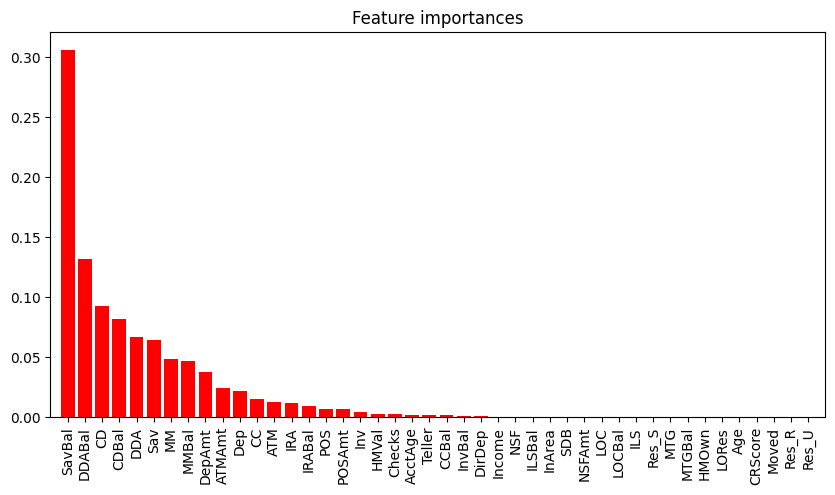

In [25]:
# plot the feature importances
importances = rfm_best.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 5))
plt.title("Feature importances")
plt.bar(range(train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(train.shape[1]), train.columns[indices], rotation=90)
plt.xlim([-1, train.shape[1]])
plt.show()
